In [1]:
import torch 
import os 

%cd /workspace/Walk_Video_PyTorch/project

from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

from utils.metrics import *

Global seed set to 42


In [2]:
from parameters import get_parameters

opt, _ = get_parameters()
opt.num_workers = 8
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

opt.clip_duraion = 1
opt.uniform_temporal_subsample_num = 16
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
opt.train_path = '/workspace/data/split_pad_dataset_512/flod2'

opt.transfor_learning = True
opt.pre_process_flag = True


In [12]:
from utils.utils import get_ckpt_path

from pytorch_lightning import loggers as pl_loggers 

# for the tensorboard
tb_logger = pl_loggers.TensorBoardLogger(save_dir="/workspace/Walk_Video_PyTorch/project/tests/logs", name=opt.model, version=opt.version)

ckpt_path = '/workspace/Walk_Video_PyTorch/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt'
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.test_dataloader()

# get last ckpt path
# ckpt_path = get_ckpt_path(opt)

# clear_output()

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/flod2
##################################################


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_list = []
label_list = []

for i, batch in enumerate(test_data):

    # input and label
    video = batch['video'].detach().cuda() # b, c, t, h, w

    label = batch['label'].detach().cuda() # b, class_num

    model.cuda().eval()

    # pred the video frames
    with torch.no_grad():
        preds = model(video)

    # when torch.size([1]), not squeeze.
    if preds.size()[0] != 1 or len(preds.size()) != 1 :
        preds = preds.squeeze(dim=-1)
        preds_sigmoid = torch.sigmoid(preds)
    else:
        preds_sigmoid = torch.sigmoid(preds)

    pred_list.append(preds_sigmoid.tolist())
    label_list.append(label.tolist())


In [14]:
total_pred_list = []
total_label_list = []

for i in pred_list:
    for number in i:
        total_pred_list.append(number)

for i in label_list:
    for number in i: 
        total_label_list.append(number)

pred = torch.tensor(total_pred_list)
label = torch.tensor(total_label_list)


In [15]:
_accuracy = get_Accuracy(1)
_precision = get_Precision(1)
_confusion_matrix = get_Confusion_Matrix()

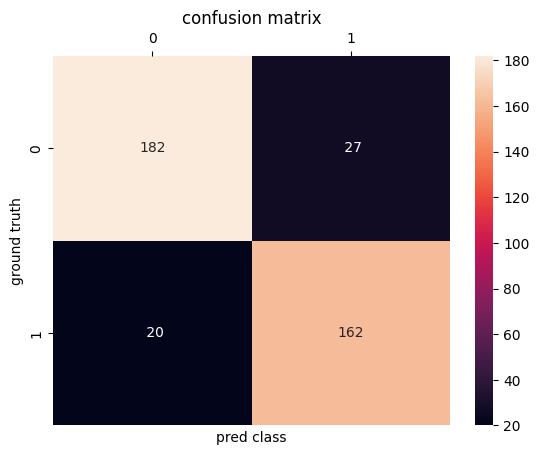

<Figure size 640x480 with 0 Axes>

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = _confusion_matrix(pred, label)

ax = sns.heatmap(cm, annot=True, fmt="3d")

ax.set_title('confusion matrix')
ax.set(xlabel="pred class", ylabel="ground truth")
ax.xaxis.tick_top()
plt.show()
plt.savefig('test.png')


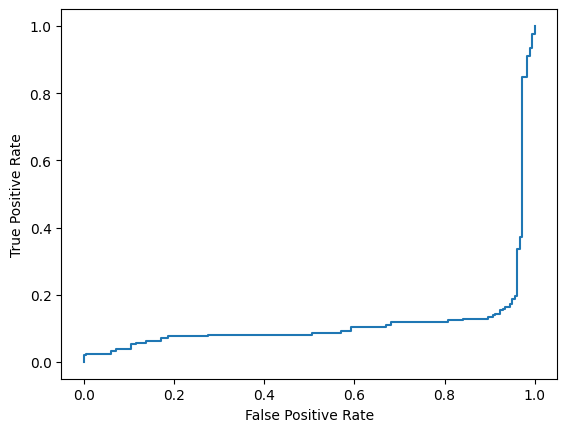

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


fpr, tpr, _ = roc_curve(label, pred, pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

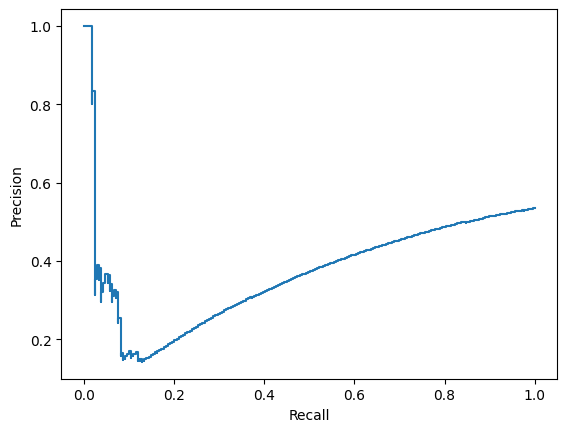

In [37]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(label, pred, pos_label=0)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

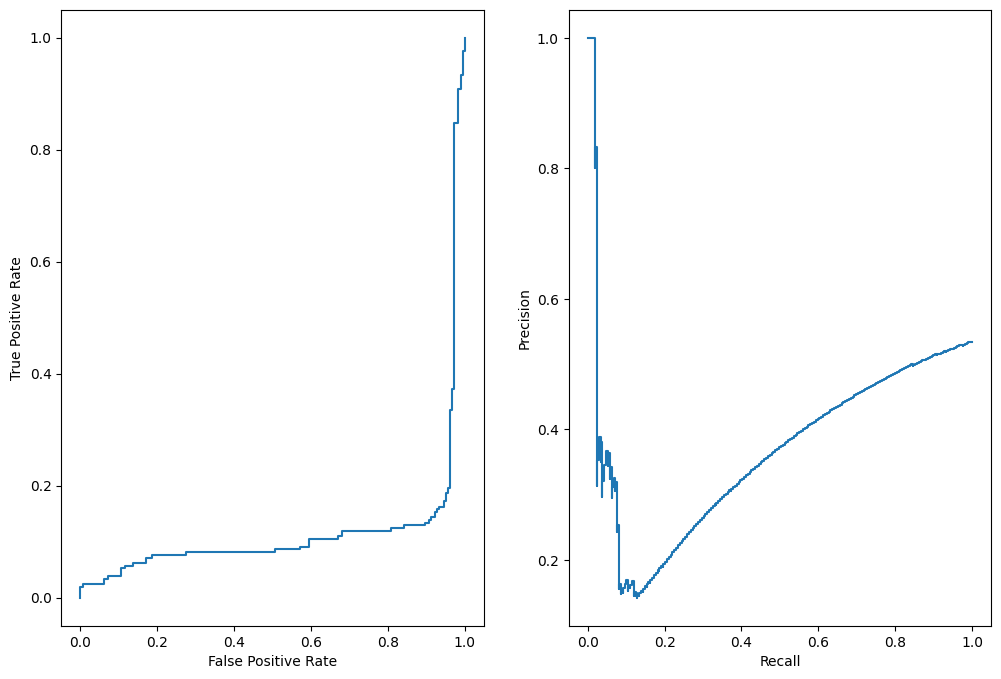

In [38]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()